In [1]:
%pylab
import pandas as pd
import seaborn as sb
import torch as T
import torch
import os
import skvideo
from tqdm import tqdm
import skvideo.io
from scipy.spatial import distance
from scipy.cluster import hierarchy
%matplotlib inline

/home/ubuntu/anaconda3/envs/pytorch_p27/lib/python2.7/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/pytorch_p27/lib/python2.7/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


Using matplotlib backend: agg
Populating the interactive namespace from numpy and matplotlib


In [2]:
plt.ioff()

In [3]:
LF_CODE_PATH = os.path.expanduser('~/projects/LFAnalyze/code')
FT_CODE_PATH = os.path.expanduser('~/projects/fishTrax/code/analysis/')
FD_CODE_PATH = os.path.expanduser('~/projects/fish_despair_notebooks/src/')
sys.path.insert(0,LF_CODE_PATH)
sys.path.insert(0,FT_CODE_PATH)
sys.path.insert(0,FD_CODE_PATH)
import passivity_2p_imaging_utils as p2putils
reload(p2putils)
tmp_dir = '/tmp/'
all_data = p2putils.get_all_datasets(tmp_dir=tmp_dir)
f = all_data['e'][2]
df = f.get_roi_table()

/home/ubuntu/anaconda3/envs/pytorch_p27/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
ortho_regions = [u'in_r_cerebellum', u'in_l_cerebellum', u'in_l_vthal',
       u'in_l_tectum', u'in_l_raphe', u'in_r_hind', u'in_l_hind',
       u'in_l_dthal', u'in_r_tectum', u'in_r_LHb', u'in_r_dthal',
       u'in_r_raphe', u'in_r_tel',
       u'in_l_MHb', u'in_l_tel', u'in_r_MHb', u'in_l_LHb', u'in_r_vthal']

regions = df.columns[np.where([c in ortho_regions for c in df.columns])]
df = df.assign(region_id=pd.Series(np.full(len(df),-1).astype(np.int32)).values)
for i, region in enumerate(regions):
    idx = np.where(df[region])[0]
    df.loc[idx, "region_id"] = i
df[regions].sum(axis=0)

in_r_LHb      290
in_r_dthal    337
in_l_vthal    435
in_r_tel      356
in_l_raphe     69
in_r_raphe     82
in_l_tel      384
in_l_LHb      381
in_l_MHb      352
in_r_vthal    426
in_r_MHb      449
in_l_dthal    293
dtype: int64

In [5]:
M = f.get_signals_raw(z=None)

In [6]:
data = np.load("cnmf_f01555.npz")
cnmf = data['cnmf']
raw = data['raw']
del data

In [7]:
def pearsonr(x, y):
    """
    Mimics `scipy.stats.pearsonr`

    Arguments
    ---------
    x : 1D torch.Tensor
    y : 1D torch.Tensor

    Returns
    -------
    r_val : float
        pearsonr correlation coefficient between x and y
    
    Scipy docs ref:
        https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html
    
    Scipy code ref:
        https://github.com/scipy/scipy/blob/v0.19.0/scipy/stats/stats.py#L2975-L3033
    Example:
        >>> x = np.random.randn(100)
        >>> y = np.random.randn(100)
        >>> sp_corr = scipy.stats.pearsonr(x, y)[0]
        >>> th_corr = pearsonr(torch.from_numpy(x), torch.from_numpy(y))
        >>> np.allclose(sp_corr, th_corr)
    """
    mean_x = torch.mean(x)
    mean_y = torch.mean(y)
    xm = x.sub(mean_x)
    ym = y.sub(mean_y)
    r_num = xm.dot(ym)
    r_den = torch.norm(xm, 2) * torch.norm(ym, 2)
    r_val = r_num / r_den
    return r_val

def corrcoef(x):
    """
    Mimics `np.corrcoef`

    Arguments
    ---------
    x : 2D torch.Tensor
    
    Returns
    -------
    c : torch.Tensor
        if x.size() = (5, 100), then return val will be of size (5,5)

    Numpy docs ref:
        https://docs.scipy.org/doc/numpy/reference/generated/numpy.corrcoef.html
    Numpy code ref: 
        https://github.com/numpy/numpy/blob/v1.12.0/numpy/lib/function_base.py#L2933-L3013

    Example:
        >>> x = np.random.randn(5,120)
        # result is a (5,5) matrix of correlations between rows
        >>> np_corr = np.corrcoef(x)
        >>> th_corr = corrcoef(torch.from_numpy(x))
        >>> np.allclose(np_corr, th_corr.numpy())
        # [out]: True
    """
    # calculate covariance matrix of rows
    mean_x = torch.mean(x, 1, keepdim=True)
    xm = x.sub(mean_x.expand_as(x))
    c = xm.mm(xm.t())
    c = c / (x.size(1) - 1)

    # normalize covariance matrix
    d = torch.diag(c)
    stddev = torch.pow(d, 0.5)
    c = c.div(stddev.expand_as(c)+1e-8)
    c = c.div(stddev.expand_as(c).t()+1e-8)

    # clamp between -1 and 1
    # probably not necessary but numpy does it
    c = torch.clamp(c, -1.0, 1.0)

    return c

In [14]:
neuron_corr_cnmf = corrcoef(T.from_numpy(cnmf.T).cuda()).cpu().numpy()

In [15]:
cnmf_linkage = hierarchy.linkage(
    distance.pdist(neuron_corr_cnmf), method='ward')

In [16]:
cm = sb.clustermap(neuron_corr_cnmf, row_linkage=cnmf_linkage, col_linkage=cnmf_linkage, method="ward",
               figsize=(16, 16))

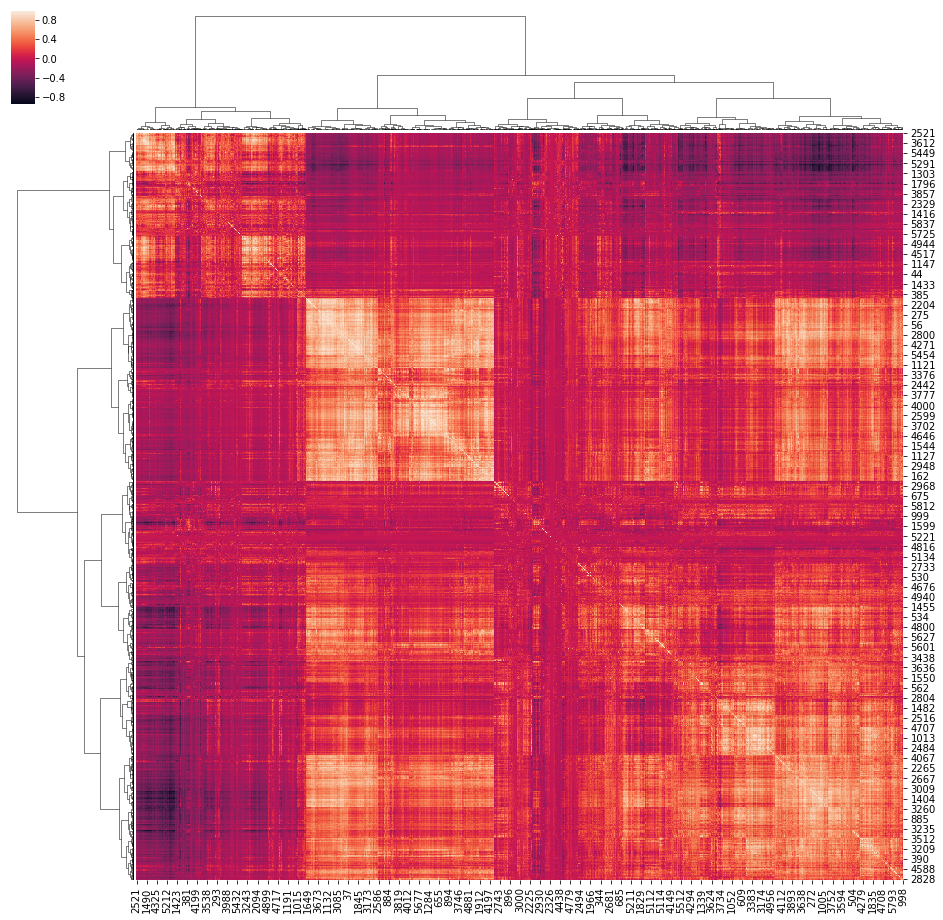

In [17]:
cm.fig

In [8]:
neuron_corr = corrcoef(T.from_numpy(M).cuda()).cpu().numpy()

In [9]:
raw_linkage = hierarchy.linkage(
    distance.pdist(neuron_corr), method='ward')

In [10]:
cm_raw = sb.clustermap(neuron_corr, row_linkage=raw_linkage, col_linkage=raw_linkage, method="ward",
               figsize=(16, 16))

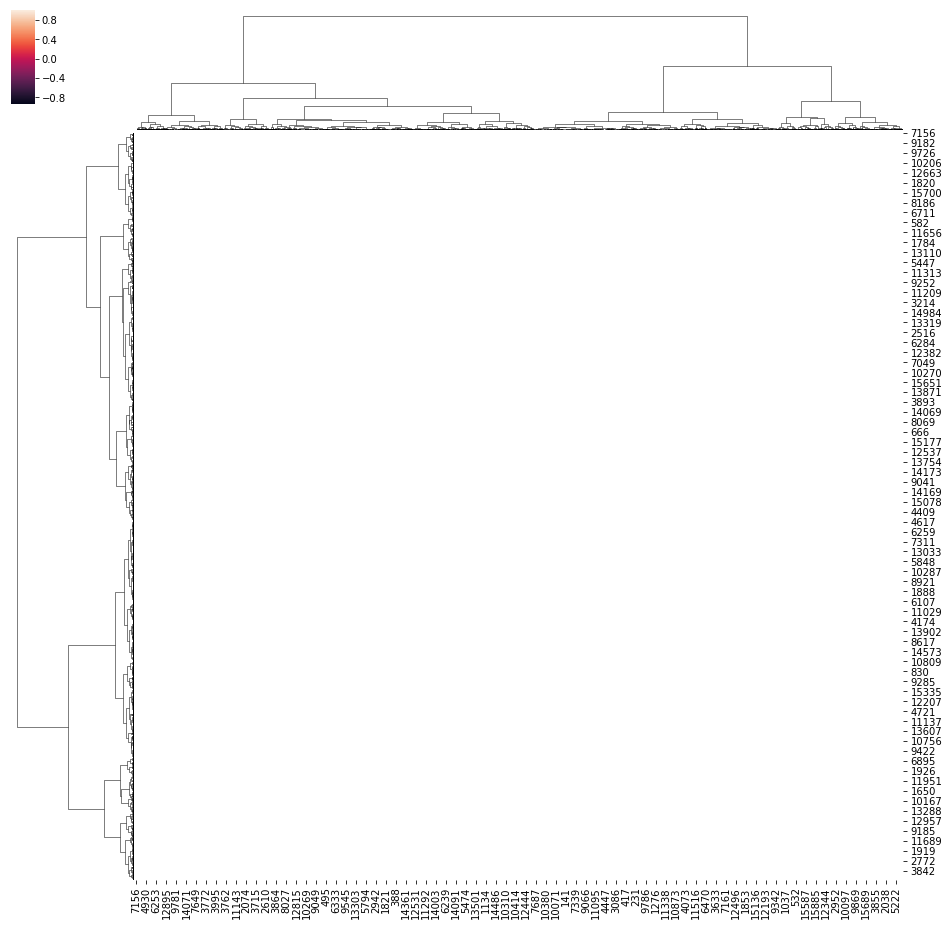

In [11]:
cm_raw.fig

In [27]:
import gc

In [12]:
def fig_to_array(fig):
    "Convert matplotlib fig into a numpy array (rgb image)"
    fig.canvas.draw()
    data = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
    data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    return data

In [29]:
winsize = 250
overlap = 0.75
start = 0
end = M.shape[1]-winsize

# use single hierarchy
writer = skvideo.io.FFmpegWriter("raw_corr_over_time.mp4", outputdict={'-b': '30000000'})

pbar = tqdm(total=end/(winsize*(1-overlap)))
while start < end:
    gc.collect()
    corr = corrcoef(T.from_numpy(M[:,start:start+winsize]).cuda()).cpu().numpy()
    cm = sb.clustermap(corr, row_linkage=raw_linkage, col_linkage=raw_linkage, method="ward",
               figsize=(15, 15))
    del corr
    f = fig_to_array(cm.fig)
    del cm
    for i in range(5):
        writer.writeFrame(f)
    del f
    start += int((winsize*(1-overlap)))
    pbar.update(1)
    plt.close('all')
pbar.close()
writer.close()


  0%|          | 0/41.216 [00:00<?, ?it/s]/home/ubuntu/anaconda3/envs/pytorch_p27/lib/python2.7/site-packages/ipykernel/__main__.py:4: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead

  2%|▏         | 1/41.216 [04:10<2:47:56, 250.55s/it]
  5%|▍         | 2/41.216 [08:15<2:42:39, 248.87s/it]
  7%|▋         | 3/41.216 [12:21<2:38:02, 248.12s/it]
 10%|▉         | 4/41.216 [16:27<2:33:27, 247.41s/it]
 12%|█▏        | 5/41.216 [20:32<2:28:55, 246.73s/it]
 15%|█▍        | 6/41.216 [24:39<2:24:44, 246.61s/it]
 17%|█▋        | 7/41.216 [28:45<2:20:40, 246.69s/it]
 19%|█▉        | 8/41.216 [32:51<2:16:18, 246.21s/it]
 22%|██▏       | 9/41.216 [36:59<2:12:36, 246.97s/it]
 24%|██▍       | 10/41.216 [41:04<2:08:08, 246.30s/it]
 27%|██▋       | 11/41.216 [45:10<2:04:00, 246.25s/it]
 29%|██▉       | 12/41.216 [49:17<2:00:03, 246.55s/it]
 32%|███▏      | 13/41.216 [53:23<1:55:51, 246.37s/it]
 34%|███▍      | 14/41.

In [19]:
winsize = 250
overlap = 0.75
start = 0
end = cnmf.shape[0]-winsize

# use single hierarchy
writer = skvideo.io.FFmpegWriter("corr_over_time.mp4", outputdict={'-b': '30000000'})

pbar = tqdm(total=end/(winsize*(1-overlap)))
while start < end:
    corr = corrcoef(T.from_numpy(cnmf[start:start+winsize].T).cuda()).cpu().numpy()
    cm = sb.clustermap(corr, row_linkage=cnmf_linkage, col_linkage=cnmf_linkage, method="ward",
               figsize=(15, 15))
    f = fig_to_array(cm.fig)
    for i in range(5):
        writer.writeFrame(f)
    start += int((winsize*(1-overlap)))
    pbar.update(1)
    plt.close('all')
pbar.close()
writer.close()

  0%|          | 0/41.216 [00:00<?, ?it/s]/home/ubuntu/anaconda3/envs/pytorch_p27/lib/python2.7/site-packages/ipykernel/__main__.py:4: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
42it [24:47, 35.45s/it]                            


In [12]:
winsize = 200
overlap = 0.75
start = 0
end = cnmf.shape[0]-winsize

# use hierarchy per frame
writer = skvideo.io.FFmpegWriter("corr_over_time_mult_hierarchy.mp4", outputdict={'-b': '30000000'})

pbar = tqdm(total=end/(winsize*(1-overlap)))
while start < end:
    corr = corrcoef(T.from_numpy(cnmf[start:start+winsize].T).cuda()).cpu().numpy()
    cm = sb.clustermap(corr, method="ward",
               figsize=(15, 15))
    f = fig_to_array(cm.fig)
    for i in range(5):
        writer.writeFrame(f)
    start += int((winsize*(1-overlap)))
    pbar.update(1)
    plt.close('all')
pbar.close()
writer.close()

  0%|          | 0/52.52 [00:00<?, ?it/s]/home/ubuntu/anaconda3/envs/pytorch_p27/lib/python2.7/site-packages/ipykernel/__main__.py:4: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
53it [2:51:54, 186.99s/it]                           


In [12]:
def plot_matrix_by_region(W, df):
    neuron_map = np.argsort(df.where(df["region_id"]>=0)["region_id"]) # no region is -1
    nHasRegion = np.sum(neuron_map!=-1) + 1 # last -1 index will be removed
    newW = np.zeros(nHasRegion,nHasRegion)
    new_order = neuron_map[np.arange(W.shape[0])]
    new_order = new_order[new_order>=0]
    newW = W[new_order]
    newW = newW[:,new_order]
    fig, ax = plt.subplots(figsize=(20,20))
    im = ax.imshow(newW)
    fig.colorbar(im)
    return fig

In [17]:
# sort by region
writer = skvideo.io.FFmpegWriter("corr_over_time_by_region.mp4", outputdict={'-b': '30000000'})

winsize = 200
overlap = 0.75
start = 0
end = cnmf.shape[0]-winsize

pbar = tqdm(total=end/(winsize*(1-overlap)))
while start < end:
    corr = corrcoef(T.from_numpy(cnmf[start:start+winsize].T).cuda()).cpu().numpy()
    fig = plot_matrix_by_region(corr,df)
    f = fig_to_array(fig)
    for i in range(5):
        writer.writeFrame(f)
    start += int((winsize*(1-overlap)))
    pbar.update(1)
    plt.close('all')
pbar.close()
writer.close()




  0%|          | 0/52.52 [00:00<?, ?it/s]/home/ubuntu/anaconda3/envs/pytorch_p27/lib/python2.7/site-packages/ipykernel/__main__.py:4: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead



  2%|▏         | 1/52.52 [00:00<00:26,  1.95it/s]


  4%|▍         | 2/52.52 [00:00<00:24,  2.07it/s]


  6%|▌         | 3/52.52 [00:01<00:22,  2.20it/s]


  8%|▊         | 4/52.52 [00:01<00:22,  2.19it/s]


 10%|▉         | 5/52.52 [00:02<00:21,  2.22it/s]


 11%|█▏        | 6/52.52 [00:02<00:20,  2.25it/s]


 13%|█▎        | 7/52.52 [00:03<00:19,  2.28it/s]


 15%|█▌        | 8/52.52 [00:03<00:19,  2.28it/s]


 17%|█▋        | 9/52.52 [00:03<00:18,  2.39it/s]


 19%|█▉        | 10/52.52 [00:04<00:17,  2.47it/s]


 21%|██        | 11/52.52 [00:04<00:16,  2.55it/s]


 23%|██▎       | 12/52.52 [00:04<00:15,  2.58it/s]


 25%|██▍       | 13/52.52 [00:05<00:15,  2.62it/s]


 27%|██▋       | 14/52.52 [00:05<00:15,  2.49i

In [13]:
f.shape

(936, 936, 3)

multi


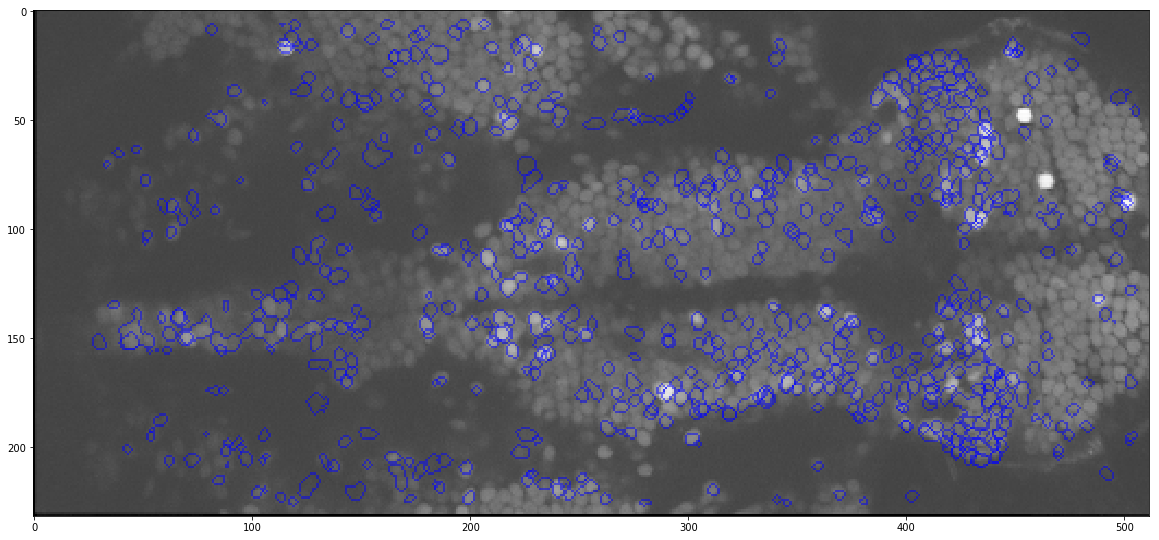

In [150]:
z=9
df, sig = f.get_cnmf_roi_table_and_signals()

#Create a background image by averaging 200 frames and adjusting the gamma.
back_img = np.power(f.get_tif_rasl_as_vol(z,range(1,200)).mean(axis=2),.4)

#Select rois in raphe in this slices, and get their coordinates.
poly_coords = df[(df.z==z)].poly
poly_coords = [np.round(poly[~np.isnan(poly).any(axis=1)])[:,(1,0)].astype(int) for poly in poly_coords]

#Overlay the ROIs on the background image and display:
img = vizutil.overlay_coords(back_img, poly_coords, [0,0,1], alpha=.5)
plt.figure(figsize=[20,20])
plt.imshow(img,interpolation='nearest')

In [151]:
cnmf_linkage_clusters = hierarchy.fcluster(cnmf_linkage,10,criterion='maxclust')
# includes all neurons, even those without cluster
cluster_by_neuron = np.zeros(cnmf.shape[1]+1)
for i,v in enumerate(cnmf_linkage_clusters):
    cluster_by_neuron[i] = v
cluster_by_neuron = cluster_by_neuron[:-1]

In [ ]:

nclust = int(cluster_by_neuron.max())
plt.subplots(nclust,1, figsize=[20,10*nclust])
for clust in range(1,nclust+1):
    #Select rois in raphe in this slices, and get their coordinates.
    poly_coords = df[(cluster_by_neuron==clust) & (df.z==z)].poly
    poly_coords = [np.round(poly[~np.isnan(poly).any(axis=1)])[:,(1,0)].astype(int) for poly in poly_coords]
    plt.subplot(nclust,1,clust)
    #Overlay the ROIs on the background image and display:
    img = vizutil.overlay_coords(back_img, poly_coords, [0,0,1], alpha=.5)
    plt.imshow(img,interpolation='nearest')
    plt.title("Cluster {}".format(clust))

multi
multi
multi
multi
multi
multi
multi
multi
multi
multi


# Archive

Text(0,0.5,'Neuron')

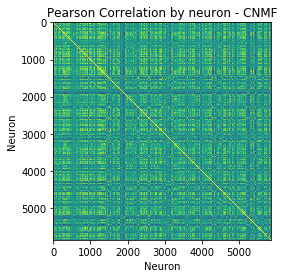

In [8]:
plt.imshow(neuron_corr_cnmf)
plt.title("Pearson Correlation by neuron - CNMF")
plt.xlabel("Neuron")
plt.ylabel("Neuron")

In [66]:
inverse_neron_map = np.zeros(len(neuron_map)+1)
for i,v in enumerate(neuron_map):
    inverse_neron_map[v] = i

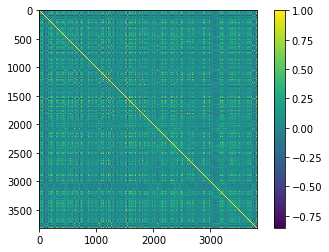

In [16]:
W = neuron_corr
neuron_map = np.argsort(df.where(df["region_id"]>=0)["region_id"]) # no region is -1
labels = np.sort(df.where(df["region_id"]>=0).dropna()["region_id"])
nHasRegion = np.sum(neuron_map!=-1) + 1 # last -1 index will be removed
newW = np.zeros(nHasRegion,nHasRegion)
new_order = neuron_map[np.arange(W.shape[0])]
new_order = new_order[new_order>=0]
newW = W[new_order]
newW = newW[:,new_order]
plt.imshow(newW)
plt.colorbar()
plt.show()

In [19]:
ward_row_linkage = hierarchy.linkage(
    distance.pdist(newW), method='ward')
ward_row_clusters = hierarchy.fcluster(ward_row_linkage,,criterion='maxclust')

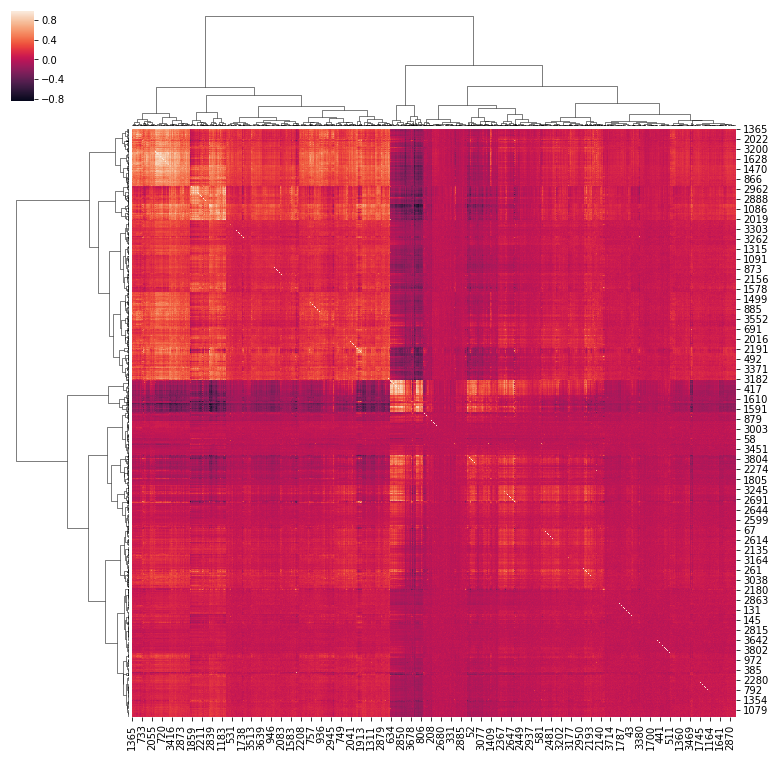

In [20]:
sb.clustermap(newW, row_linkage=ward_row_linkage, method="ward",
               figsize=(13, 13))

In [7]:
time_corr = corrcoef(T.from_numpy(M.T).cuda()).cpu().numpy()

Text(0,0.5,'Time')

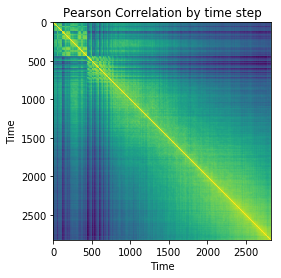

In [8]:
plt.imshow(time_corr)
plt.title("Pearson Correlation by time step")
plt.xlabel("Time")
plt.ylabel("Time")

In [9]:
time_corr_cnmf = corrcoef(T.from_numpy(cnmf).cuda()).cpu().numpy()

In [23]:
f.frame_et.mean(1)

array([  12.91531818,   13.90221818,   14.88923636, ..., 2799.18340909,
       2800.1704    , 2801.1574    ])

Text(0,0.5,'Time')

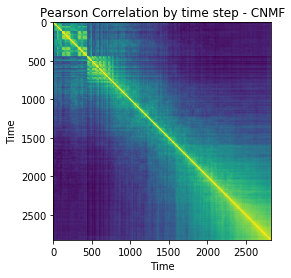

In [10]:
plt.imshow(time_corr_cnmf)
plt.title("Pearson Correlation by time step - CNMF")
plt.xlabel("Time")
plt.ylabel("Time")

In [11]:
neuron_corr = corrcoef(T.from_numpy(M).cuda()).cpu().numpy()

Text(0,0.5,'Neuron')

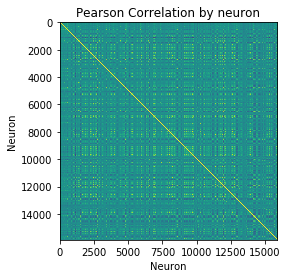

In [12]:
plt.imshow(neuron_corr)
plt.title("Pearson Correlation by neuron")
plt.xlabel("Neuron")
plt.ylabel("Neuron")